# Deep Fake Detection with ConvNeXt

This notebook implements a deep learning model for detecting fake vs. real images using the ConvNeXt Tiny architecture.

## 1. Setup and Environment

In [2]:
import torch  # Import PyTorch

# device var
device = "cuda" if torch.cuda.is_available() else "cpu"

# Print GPU details if available, else inform that CPU is being used
if torch.cuda.is_available():
    print(f"Using GPU: {torch.cuda.get_device_name(0)}")
else:
    print("Running on CPU")


Using GPU: Tesla T4


### Install Required Libraries

In [ ]:
# Install necessary libraries
!pip install torch torchvision datasets timm

## 2. Dataset Preparation

Downloading and preparing the dataset from HuggingFace.

In [5]:
# Download & Prepare Dataset
import os
import zipfile
import requests
from torchvision.datasets import ImageFolder
from torchvision import transforms
from torch.utils.data import DataLoader, random_split
from datasets import load_dataset

# Dataset repo & file URL
# Dataset with 70k Real and 70k Fake
# repo_id = "yashduhan/DeepFakeDetection"
repo_id = "yashduhan/deepfake-detection-700"  # Dataset with 700 Real and 700 Fake
dataset_url = f"https://huggingface.co/datasets/{repo_id}/resolve/main/DeepFakeDetection.zip"
dataset_dir = "./DeepFakeDetection"
flag_file = os.path.join(dataset_dir, ".downloaded")

zip_path = "DeepFakeDetection.zip"
if not os.path.exists(flag_file):
    try:
        print("Downloading dataset...")
        response = requests.get(dataset_url, stream=True, timeout=10)
        response.raise_for_status()
        total_size = int(response.headers.get("content-length", 0))
        downloaded_size = 0

        with open(zip_path, "wb") as f:
            for chunk in response.iter_content(chunk_size=1024):
                if chunk:
                    f.write(chunk)
                    downloaded_size += len(chunk)
                    print(f"\rDownloaded: {downloaded_size / total_size * 100:.2f}%", end="", flush=True)

        print("\nExtracting dataset...")
        with zipfile.ZipFile(zip_path, "r") as zip_ref:
            zip_ref.extractall(".")
        os.remove(zip_path)

        # Create a flag file to indicate success
        with open(flag_file, "w") as f:
            f.write("downloaded")
    except requests.exceptions.RequestException as e:
        print("Error downloading dataset:", e)
else:
    print("Dataset already downloaded.")


Dataset already downloaded.


### Data Preprocessing and Augmentation

Setting up transformations and splitting the dataset for training, validation, and testing.

In [6]:
# Data Preprocessing & Augmentation
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),  # Data Augmentation
    transforms.RandomRotation(10),      # Small Rotation
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load dataset using ImageFolder
dataset = ImageFolder(root=dataset_dir, transform=transform)

# Split for Training (80%), Validation (10%), and Test (10%)
train_size = int(0.8 * len(dataset))
val_size = int(0.1 * len(dataset))
test_size = len(dataset) - train_size - val_size

# Perform the dataset split
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

# DataLoader for training, validation, and testing
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)

# Print dataset details
print(f"Class Mapping: {dataset.class_to_idx}")
print(f"Total Images: {len(dataset)} | Train: {train_size} | Val: {val_size} | Test: {test_size}")

Class Mapping: {'fake': 0, 'real': 1}
Total Images: 1400 | Train: 1120 | Val: 140 | Test: 140


## 3. Model Architecture

Building the ConvNeXt Tiny model for deep fake detection.

In [ ]:
# Initialize Model, Optimizer, and Loss Function
import torch.nn as nn
import timm

# Define the model
class DeepFakeModel(nn.Module):
    def __init__(self, num_classes=2):
        super(DeepFakeModel, self).__init__()
        # Create the base model without its classification head
        self.model = timm.create_model("convnext_tiny", pretrained=True, num_classes=0)

        # Create a new classifier head (ConvNeXt Tiny has 768 features output)
        self.classifier = nn.Linear(768, num_classes)

    def forward(self, x):
        features = self.model(x)
        return self.classifier(features)

# Initialize model and training components
model = DeepFakeModel().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

### Model Verification

Ensuring we're using the ConvNeXt architecture.

In [8]:
# Verify model architecture
def verify_model_architecture(model):
    return 'convnext' in str(model.model).lower()

# Verify our model and fix if needed
if not verify_model_architecture(model):
    print("The model is not using ConvNeXt architecture. Creating a new one.")
    model = DeepFakeModel().to(device)

## 4. Model Training

Training the ConvNeXt model on the deepfake dataset.

In [9]:
# Training Function
def train_model(model, train_loader, val_loader, epochs=5):
    # Ensure we're using ConvNeXt
    if not verify_model_architecture(model):
        model = DeepFakeModel().to(device)

    print("Training Started...")

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct, total = 0, 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

        train_acc = correct / total * 100
        print(f"Epoch {epoch+1}/{epochs} | Loss: {running_loss/len(train_loader):.4f} | Acc: {train_acc:.2f}%")

    print("Training Completed!")
    return model

# Train the model
model = train_model(model, train_loader, val_loader)

Training Started...
Epoch 1/5 | Loss: 1.2206 | Acc: 48.04%
Epoch 2/5 | Loss: 0.7138 | Acc: 49.82%
Epoch 3/5 | Loss: 0.7029 | Acc: 50.36%
Epoch 4/5 | Loss: 0.7308 | Acc: 49.11%
Epoch 5/5 | Loss: 0.7031 | Acc: 49.29%
Training Completed!


## 5. Model Evaluation and Export

Validating model performance and saving the trained model.

In [10]:
# Evaluate and Save Model
def evaluate_model(model, val_loader):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    val_acc = correct / total * 100
    print(f"Validation Accuracy: {val_acc:.2f}%")
    return val_acc

# Save model
import json
!mkdir -p model_export
torch.save(model.state_dict(), "model_export/deepfake_detector.pth")

# Save model config
model_info = {
    "architecture": "ConvNeXt Tiny",
    "input_size": [224, 224],
    "class_mapping": dataset.class_to_idx,
    "normalize_mean": [0.485, 0.456, 0.406],
    "normalize_std": [0.229, 0.224, 0.225]
}

with open("model_export/model_info.json", "w") as f:
    json.dump(model_info, f, indent=4)

# Create and download zip
!zip -r deepfake_model.zip model_export/
from google.colab import files
files.download('deepfake_model.zip')

# Evaluate model
val_accuracy = evaluate_model(model, val_loader)

  adding: model_export/ (stored 0%)
  adding: model_export/deepfake_detector.pth (deflated 7%)
  adding: model_export/model_info.json (deflated 48%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Validation Accuracy: 55.71%


## 6. Image Detection Testing

### Setting up prediction utilities

In [11]:
# Image prediction utilities
%matplotlib inline
import matplotlib.pyplot as plt
from PIL import Image
import io
import os
from torchvision import transforms
from google.colab import files
import numpy as np

def predict_image(model, image_tensor, device):
    model.eval()
    with torch.no_grad():
        image_tensor = image_tensor.unsqueeze(0).to(device)
        outputs = model(image_tensor)
        probabilities = torch.nn.functional.softmax(outputs, dim=1)
        return probabilities[0].cpu().numpy()

# Create inference transform
inference_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Create two models for comparison
original_model = DeepFakeModel().to(device)  # Pretrained only
fine_tuned_model = model  # Trained model
fine_tuned_model.eval()

DeepFakeModel(
  (model): ConvNeXt(
    (stem): Sequential(
      (0): Conv2d(3, 96, kernel_size=(4, 4), stride=(4, 4))
      (1): LayerNorm2d((96,), eps=1e-06, elementwise_affine=True)
    )
    (stages): Sequential(
      (0): ConvNeXtStage(
        (downsample): Identity()
        (blocks): Sequential(
          (0): ConvNeXtBlock(
            (conv_dw): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)
            (norm): LayerNorm((96,), eps=1e-06, elementwise_affine=True)
            (mlp): Mlp(
              (fc1): Linear(in_features=96, out_features=384, bias=True)
              (act): GELU()
              (drop1): Dropout(p=0.0, inplace=False)
              (norm): Identity()
              (fc2): Linear(in_features=384, out_features=96, bias=True)
              (drop2): Dropout(p=0.0, inplace=False)
            )
            (shortcut): Identity()
            (drop_path): Identity()
          )
          (1): ConvNeXtBlock(
            (conv_dw): Con

### Testing on Sample Images

Testing the model on sample images from the dataset.

In [12]:
# Test on dataset samples
def test_dataset_images():
    print("Testing on sample images from dataset...")

    # Get image paths
    fake_path = os.path.join(dataset_dir, "fake")
    real_path = os.path.join(dataset_dir, "real")
    fake_files = os.listdir(fake_path)[:3]
    real_files = os.listdir(real_path)[:3]

    all_files = [(os.path.join(fake_path, f), 'fake') for f in fake_files] + \
                [(os.path.join(real_path, f), 'real') for f in real_files]

    results = []

    for img_path, true_label in all_files:
        # Process image
        image = Image.open(img_path).convert('RGB')
        image_tensor = inference_transform(image)

        # Get predictions
        probs = predict_image(fine_tuned_model, image_tensor, device)
        pred_label = "real" if probs[1] > probs[0] else "fake"

        # Store results
        results.append({
            "path": img_path,
            "true": true_label,
            "pred": pred_label,
            "probs": probs,
            "correct": true_label == pred_label
        })

        # Display results
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
        ax1.imshow(image)
        ax1.set_title(f"True: {true_label}")
        ax1.axis('off')
        ax2.bar(['Fake', 'Real'], probs, color=['red', 'green'])
        ax2.set_title(f"Prediction: {pred_label}")
        ax2.set_ylim(0, 1)
        plt.tight_layout()
        plt.show()

        print(f"File: {os.path.basename(img_path)}")
        print(f"Prediction: {pred_label} | Fake: {probs[0]:.2f} | Real: {probs[1]:.2f}")
        print(f"Correct: {true_label == pred_label}")
        print("-" * 30)

    # Summary
    correct = sum(1 for r in results if r["correct"])
    print(f"Accuracy: {correct}/{len(results)} ({correct/len(results):.2%})")
    return results

# Function to analyze uploaded images
def analyze_image():
    print("\nUpload an image to analyze...")
    uploaded = files.upload()

    for filename in uploaded.keys():
        # Process image
        image_bytes = uploaded[filename]
        image = Image.open(io.BytesIO(image_bytes))
        if image.mode != 'RGB':
            image = image.convert('RGB')

        image_tensor = inference_transform(image)

        # Get predictions
        original_probs = predict_image(original_model, image_tensor, device)
        fine_tuned_probs = predict_image(fine_tuned_model, image_tensor, device)

        # Visualization
        labels = ['Fake', 'Real']
        x = np.arange(len(labels))
        width = 0.35

        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
        ax1.bar(x - width/2, original_probs, width, label='Pretrained', color='lightblue')
        ax1.bar(x + width/2, fine_tuned_probs, width, label='Fine-tuned', color='lightgreen')
        ax1.set_ylabel('Probability')
        ax1.set_title('Model Predictions')
        ax1.set_xticks(x)
        ax1.set_xticklabels(labels)
        ax1.legend()
        ax1.set_ylim(0, 1)
        ax1.grid(True, alpha=0.3)

        ax2.imshow(image)
        ax2.axis('off')
        ax2.set_title(f'Image: {filename}')

        plt.tight_layout()
        plt.show()

        # Print results
        print(f"Results for {filename}:")
        prediction = "Real" if fine_tuned_probs[1] > fine_tuned_probs[0] else "Fake"
        confidence = max(fine_tuned_probs[0], fine_tuned_probs[1])
        print(f"Prediction: {prediction} (Confidence: {confidence:.2%})")
        print(f"Fake: {fine_tuned_probs[0]:.2%} | Real: {fine_tuned_probs[1]:.2%}")

### Test and Analyze Images

Run sample testing and allow uploading custom images for analysis.

Testing on sample images from dataset...


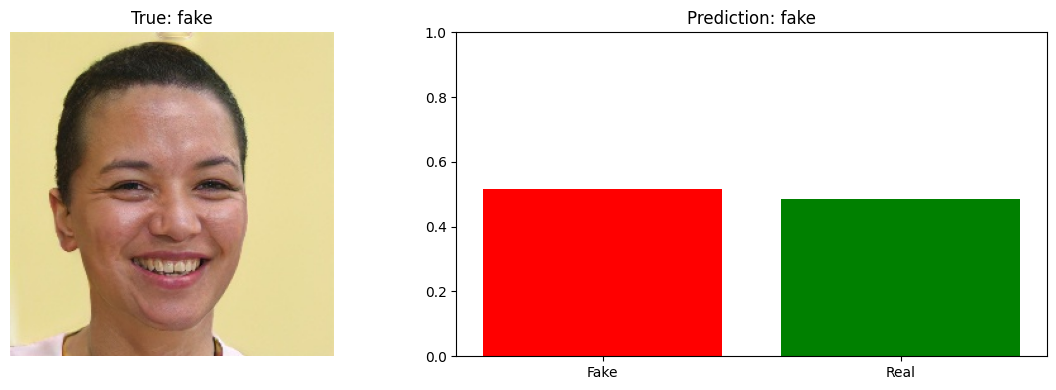

File: 045GMHS2UG.jpg
Prediction: fake | Fake: 0.52 | Real: 0.48
Correct: True
------------------------------


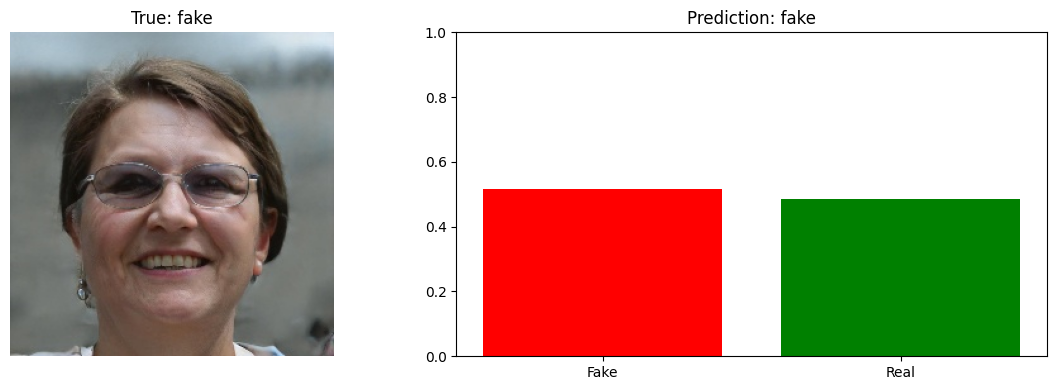

File: 01IUWPPCNT.jpg
Prediction: fake | Fake: 0.52 | Real: 0.48
Correct: True
------------------------------


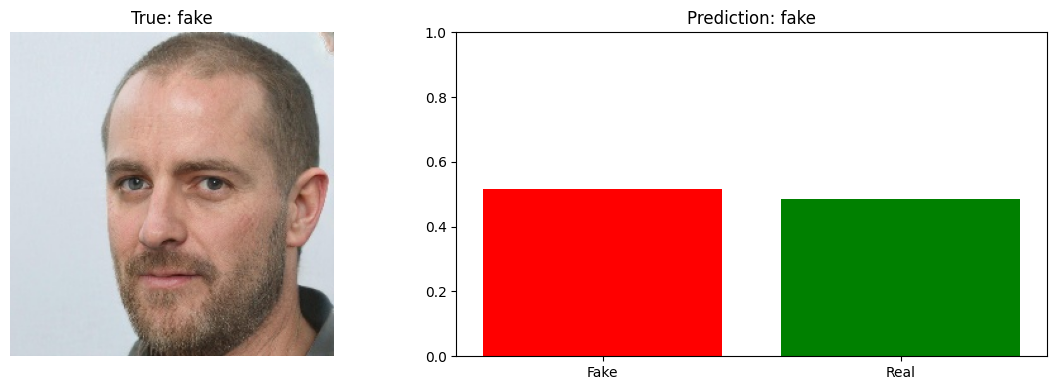

File: 03OHTGNZ8P.jpg
Prediction: fake | Fake: 0.52 | Real: 0.48
Correct: True
------------------------------


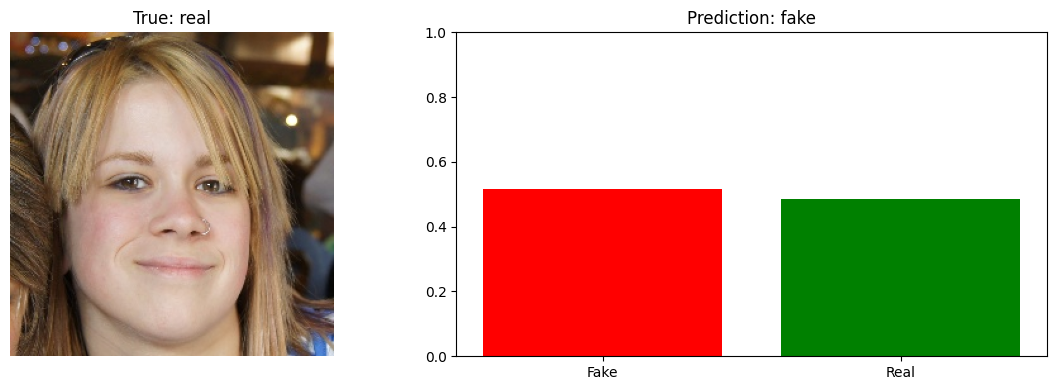

File: 00215.jpg
Prediction: fake | Fake: 0.52 | Real: 0.48
Correct: False
------------------------------


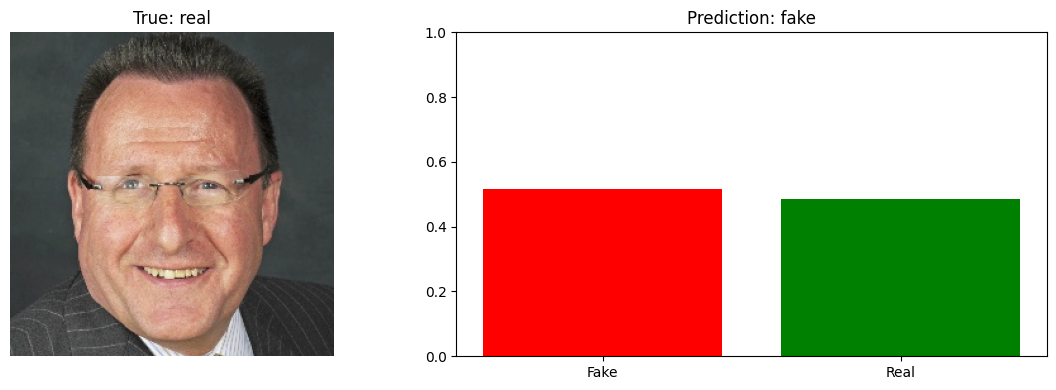

File: 00439.jpg
Prediction: fake | Fake: 0.52 | Real: 0.48
Correct: False
------------------------------


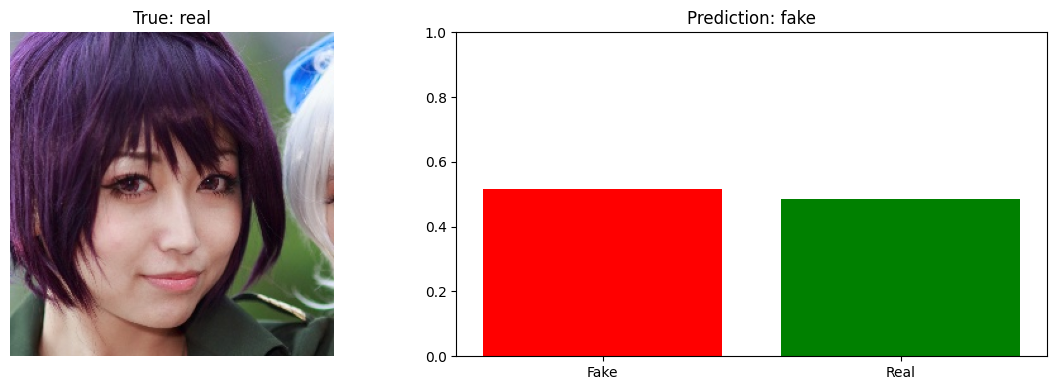

File: 00208.jpg
Prediction: fake | Fake: 0.52 | Real: 0.48
Correct: False
------------------------------
Accuracy: 3/6 (50.00%)

Ready to analyze your own images!

Upload an image to analyze...


Saving ChatGPT Image Apr 3, 2025, 02_33_15 PM.png to ChatGPT Image Apr 3, 2025, 02_33_15 PM.png


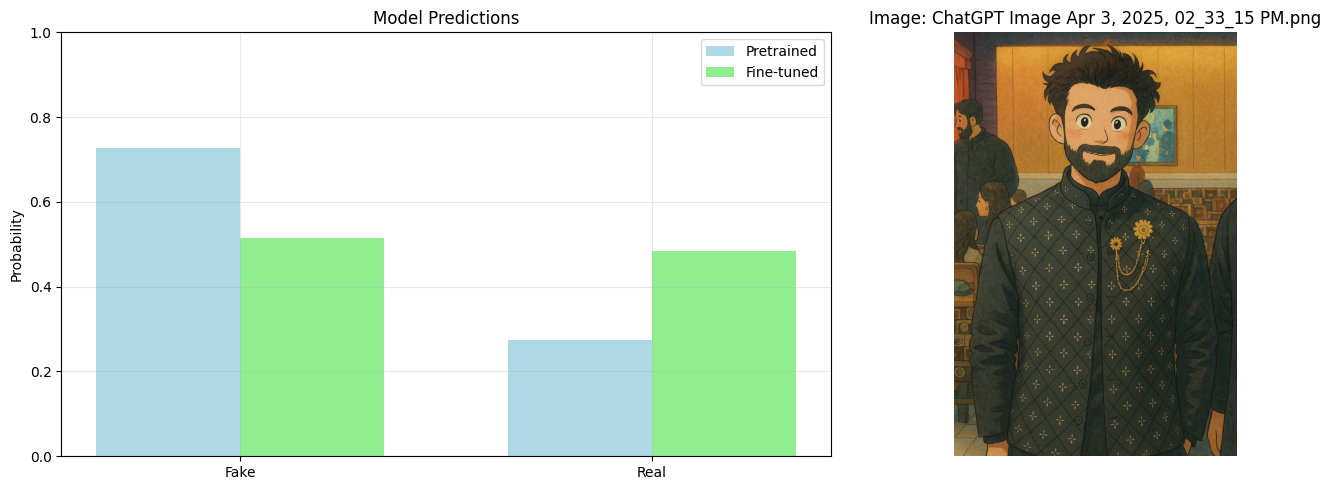

Results for ChatGPT Image Apr 3, 2025, 02_33_15 PM.png:
Prediction: Fake (Confidence: 51.55%)
Fake: 51.55% | Real: 48.45%


In [13]:
# Run tests
dataset_results = test_dataset_images()
print("\nReady to analyze your own images!")
analyze_image()